In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
%matplotlib inline

In [3]:
def mostrar_imagenes(image_array, num_images=25, size=(28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_plot = image_array.reshape(-1, *size)
#     plt.figure(figsize=(15, 4.5))
    for i in range(num_images):
        plt.subplot(5, int(num_images) / 5, i + 1)
        plt.imshow(image_plot[i].astype(np.uint8), cmap=plt.cm.binary)
        plt.axis('off')
    plt.show()

In [4]:
def obtener_bloque_generador(dim_entrada: int, dim_salida: int) -> tf.keras.Model:
    ''' Genera una capa lineal con normalización por bloques '''
    entrada = tf.keras.Input(shape=dim_entrada)
    capa_lineal = tf.keras.layers.Dense(units=dim_salida)(entrada)
    normalizacion = tf.keras.layers.BatchNormalization()(capa_lineal)
    salida_relu = tf.keras.activations.relu(normalizacion)
    return tf.keras.Model(inputs=entrada, outputs=salida_relu)

def obtener_generador(dim_z: int = 10, dim_imagen: int = 784, dim_oculta: int = 128) -> tf.keras.Model:
    ''' Generador de imágenes '''
    entrada = tf.keras.Input(shape=dim_z)
    salida_1 = obtener_bloque_generador(dim_entrada=dim_z, dim_salida=dim_oculta)(entrada)
    salida_2 = obtener_bloque_generador(dim_entrada=dim_oculta, dim_salida=dim_oculta*2)(salida_1)
    salida_3 = obtener_bloque_generador(dim_entrada=dim_oculta*2, dim_salida=dim_oculta*4)(salida_2)
    salida_4 = obtener_bloque_generador(dim_entrada=dim_oculta*4, dim_salida=dim_oculta*8)(salida_3)
    salida_lineal = tf.keras.layers.Dense(units=dim_imagen)(salida_4)
    salida_sigmoide = tf.keras.activations.sigmoid(salida_lineal)
    return tf.keras.Model(inputs=entrada, outputs=salida_sigmoide)

In [5]:
obtener_generador().summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
model (Functional)           (None, 128)               1920      
_________________________________________________________________
model_1 (Functional)         (None, 256)               34048     
_________________________________________________________________
model_2 (Functional)         (None, 512)               133632    
_________________________________________________________________
model_3 (Functional)         (None, 1024)              529408    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
_________________________________________________________________
tf.math.sigmoid (TFOpLambda) (None, 784)               0   

In [6]:
def obtener_ruido(numero_muestra: int, dim_z: int) -> tf.random.normal:
    ''' Genera vector aleatorios de dimension (numero_muestra, dim_z) '''
    return tf.random.normal((numero_muestra, dim_z))

In [7]:
obtener_ruido(2, 10)

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[-0.22558273, -0.23957922,  0.34811464, -0.4451526 ,  0.11240102,
        -2.2354648 , -1.1956106 ,  1.6070544 ,  0.66093975,  1.3644788 ],
       [-0.52683824,  0.61363095,  1.3773885 ,  1.7723303 , -0.0613577 ,
         0.77663255, -0.46138787,  1.6431087 ,  0.2362125 , -0.3936499 ]],
      dtype=float32)>

In [8]:
def obtener_bloque_discriminador(dim_entrada: int, dim_salida: int) -> tf.keras.Model:
    ''' Genera una capa lineal con normalización por bloques '''
    entrada = tf.keras.Input(shape=dim_entrada)
    capa_lineal = tf.keras.layers.Dense(units=dim_salida)(entrada)
    salida_leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
    return tf.keras.Model(inputs=entrada, outputs=salida_leaky_relu)

def obtener_discriminador(dim_imagen: int = 784, dim_oculta: int = 128) -> tf.keras.Model:
    ''' Generador de imágenes '''
    entrada = tf.keras.Input(shape=dim_imagen)
    salida_1 = obtener_bloque_generador(dim_entrada=dim_imagen, dim_salida=dim_oculta*4)(entrada)
    salida_2 = obtener_bloque_generador(dim_entrada=dim_oculta*4, dim_salida=dim_oculta*2)(salida_1)
    salida_3 = obtener_bloque_generador(dim_entrada=dim_oculta*2, dim_salida=dim_oculta)(salida_2)
    salida_lineal = tf.keras.layers.Dense(units=1)(salida_3)
    return tf.keras.Model(inputs=entrada, outputs=salida_lineal)

In [9]:
obtener_discriminador().summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
model_5 (Functional)         (None, 512)               403968    
_________________________________________________________________
model_6 (Functional)         (None, 256)               132352    
_________________________________________________________________
model_7 (Functional)         (None, 128)               33408     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 569,857
Trainable params: 568,065
Non-trainable params: 1,792
_________________________________________________________________


In [10]:
def obtener_perdida_discriminador(generador: tf.keras.Model, discriminador: tf.keras.Model, imagenes_real, num_imagenes, dim_z):
    ''' Obtiene perdida del discriminador '''
    rudio = obtener_ruido(numero_muestra=num_imagenes, dim_z=dim_z)
    imagenes_falsa = generador(rudio)
    prediccion_falsa = discriminador(tf.stop_gradient(imagenes_falsa))
    target_falsa = tf.zeros_like(prediccion_falsa)
    perdida_falsa = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target_falsa, logits=prediccion_falsa))
    
    prediccion_real = discriminador(imagenes_real)
    target_real = tf.ones_like(prediccion_real)
    perdida_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target_real, logits=prediccion_real))

    perdida_discriminador = (perdida_falsa + perdida_real) / 2
    return perdida_discriminador

In [11]:
def obtener_perdida_generador(generador, discriminador, num_imagenes, dim_z):
    rudio = obtener_ruido(numero_muestra=num_imagenes, dim_z=dim_z)
    imagenes_falsa = generador(rudio)
    prediccion_falsa = discriminador(imagenes_falsa)
    target_falsa = tf.ones_like(prediccion_falsa)
    perdida_generador = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target_falsa, logits=prediccion_falsa))
    return perdida_generador

In [12]:
def obtener_mnist_data(batch_size=128):
    (mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = tf.keras.datasets.mnist.load_data()
    mnist_x_train = mnist_x_train.reshape(-1, 784)
    mnist_x_test = mnist_x_test.reshape(-1, 784)
    mnist_data = np.concatenate((mnist_x_train, mnist_x_test), axis=0)
    mnist_data = mnist_data / 255.0
    mnist_target = np.concatenate((mnist_y_train, mnist_y_test), axis=0)
    dataset = tf.data.Dataset.from_tensor_slices((mnist_data, mnist_target))
    dataset = dataset.shuffle(len(mnist_data)).batch(batch_size)
    return dataset

In [13]:
dataset = obtener_mnist_data(1024)

In [14]:
generador = obtener_generador(dim_z=64)
generador_optimizador = tf.keras.optimizers.Adam(learning_rate=0.0001)

discriminador = obtener_discriminador()
discriminador_optimizador = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [15]:
dim_z = 64
n_epochs = 200

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:27<00:00,  2.51it/s]


tf.Tensor(0.010020768, shape=(), dtype=float32)
tf.Tensor(0.122095436, shape=(), dtype=float32)


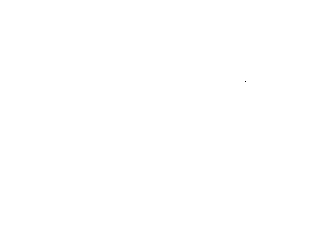

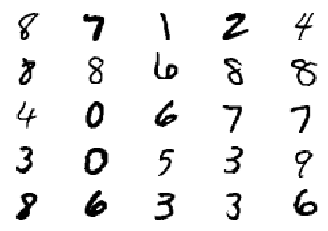

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:27<00:00,  2.51it/s]


tf.Tensor(0.011706076, shape=(), dtype=float32)
tf.Tensor(0.35973826, shape=(), dtype=float32)


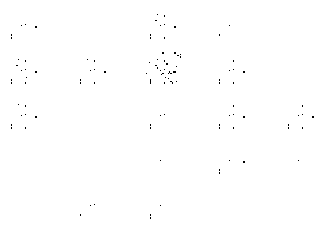

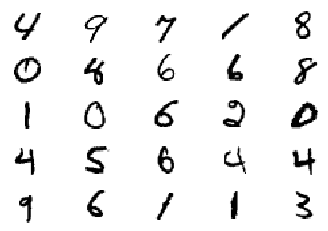

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:33<00:00,  2.08it/s]


tf.Tensor(0.012594782, shape=(), dtype=float32)
tf.Tensor(0.62957394, shape=(), dtype=float32)


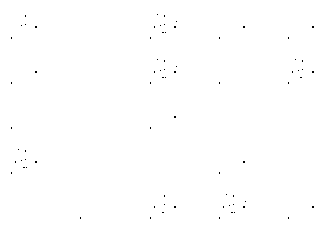

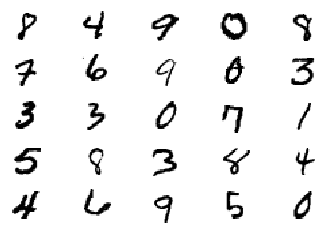

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.67it/s]


tf.Tensor(0.01370817, shape=(), dtype=float32)
tf.Tensor(0.9073741, shape=(), dtype=float32)


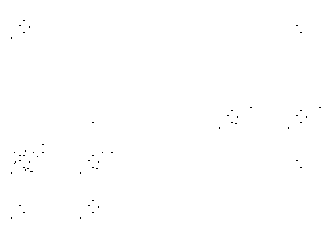

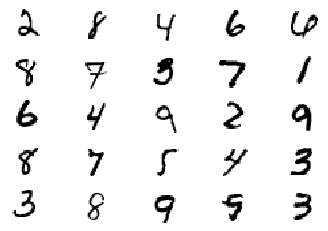

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.68it/s]


tf.Tensor(0.0146250045, shape=(), dtype=float32)
tf.Tensor(1.2099661, shape=(), dtype=float32)


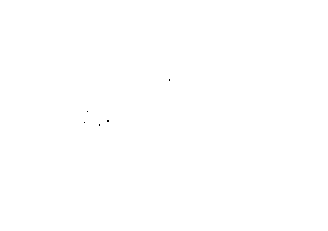

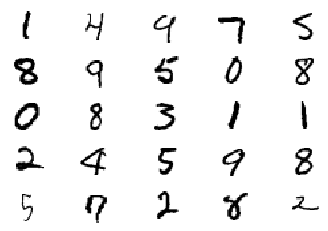

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:28<00:00,  2.39it/s]


tf.Tensor(0.016388753, shape=(), dtype=float32)
tf.Tensor(1.4913924, shape=(), dtype=float32)


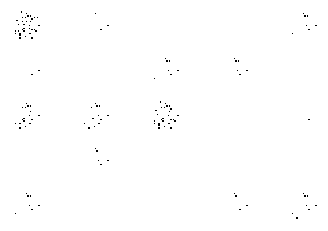

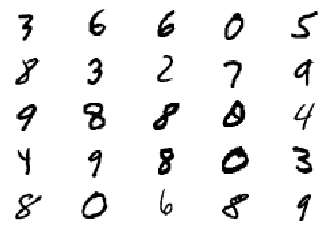

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.71it/s]


tf.Tensor(0.017050143, shape=(), dtype=float32)
tf.Tensor(1.806054, shape=(), dtype=float32)


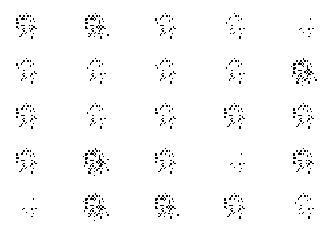

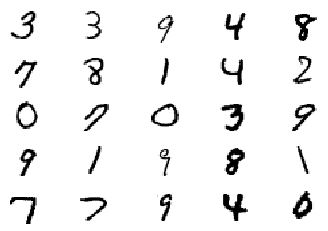

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.76it/s]


tf.Tensor(0.01756421, shape=(), dtype=float32)
tf.Tensor(2.1510987, shape=(), dtype=float32)


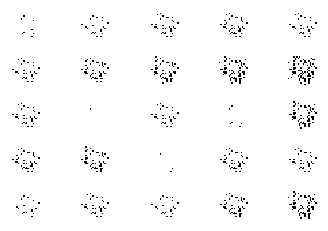

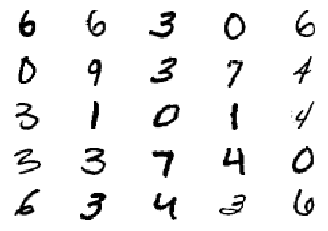

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:25<00:00,  2.72it/s]


tf.Tensor(0.0182522, shape=(), dtype=float32)
tf.Tensor(2.4671245, shape=(), dtype=float32)


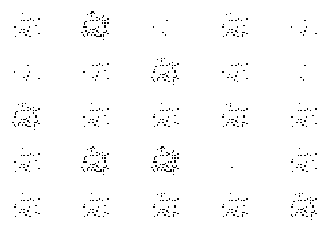

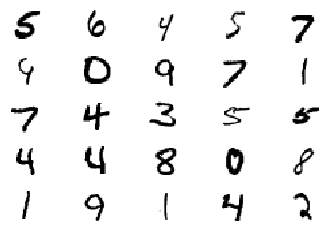

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:32<00:00,  2.09it/s]


tf.Tensor(0.01890255, shape=(), dtype=float32)
tf.Tensor(2.7888393, shape=(), dtype=float32)


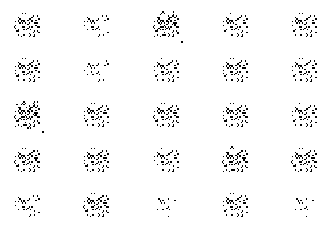

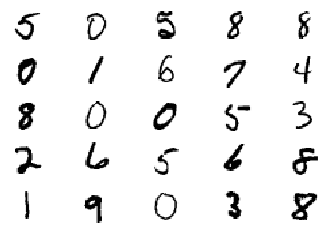

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:31<00:00,  2.16it/s]


tf.Tensor(0.019272896, shape=(), dtype=float32)
tf.Tensor(3.139603, shape=(), dtype=float32)


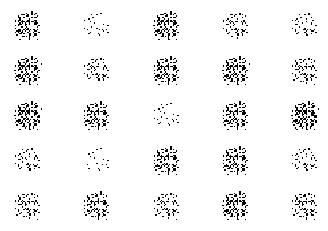

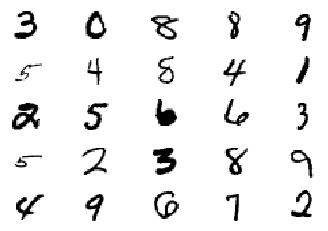

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:26<00:00,  2.64it/s]


tf.Tensor(0.01951688, shape=(), dtype=float32)
tf.Tensor(3.5272725, shape=(), dtype=float32)


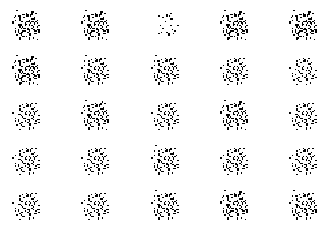

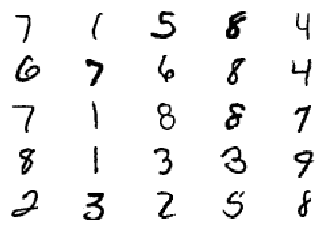

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:27<00:00,  2.53it/s]


tf.Tensor(0.019684192, shape=(), dtype=float32)
tf.Tensor(3.9189246, shape=(), dtype=float32)


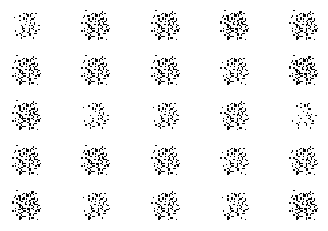

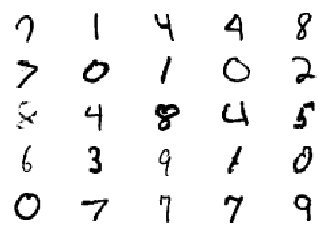

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:32<00:00,  2.14it/s]


tf.Tensor(0.019781223, shape=(), dtype=float32)
tf.Tensor(4.3533516, shape=(), dtype=float32)


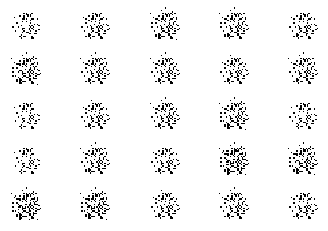

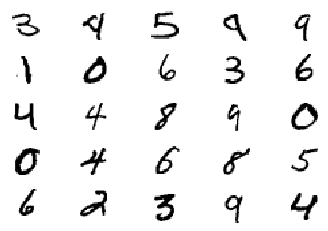

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:34<00:00,  1.99it/s]


tf.Tensor(0.019858653, shape=(), dtype=float32)
tf.Tensor(4.7954865, shape=(), dtype=float32)


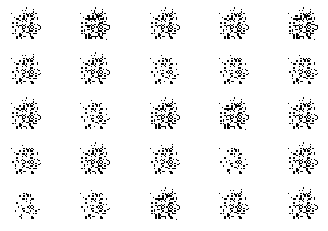

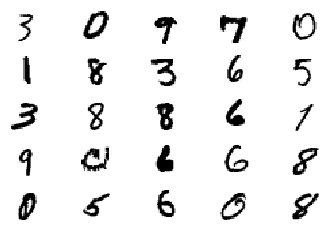

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:34<00:00,  1.98it/s]


tf.Tensor(0.019943245, shape=(), dtype=float32)
tf.Tensor(5.244491, shape=(), dtype=float32)


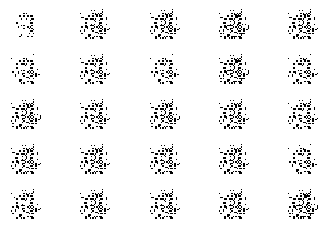

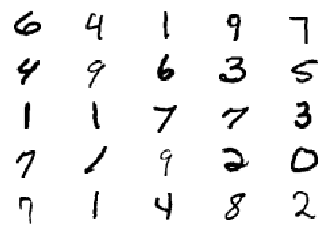

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:28<00:00,  2.42it/s]


tf.Tensor(0.02009558, shape=(), dtype=float32)
tf.Tensor(5.6756926, shape=(), dtype=float32)


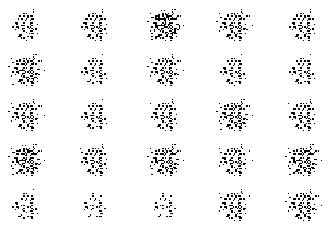

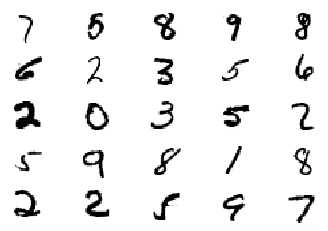

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:33<00:00,  2.05it/s]


tf.Tensor(0.020135753, shape=(), dtype=float32)
tf.Tensor(6.154452, shape=(), dtype=float32)


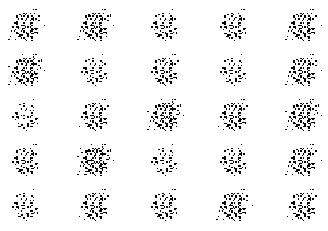

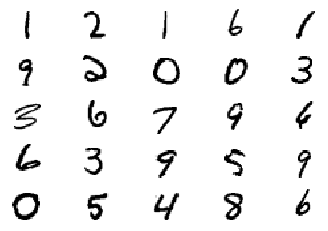

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:31<00:00,  2.16it/s]


tf.Tensor(0.020263312, shape=(), dtype=float32)
tf.Tensor(6.6238146, shape=(), dtype=float32)


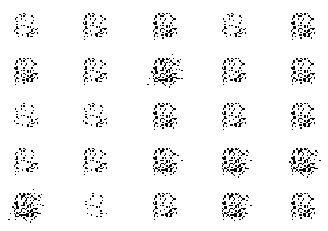

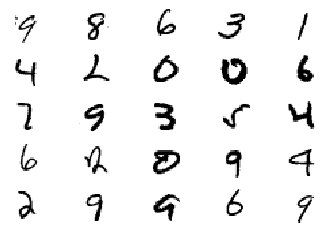

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:31<00:00,  2.18it/s]


tf.Tensor(0.020457858, shape=(), dtype=float32)
tf.Tensor(7.0430408, shape=(), dtype=float32)


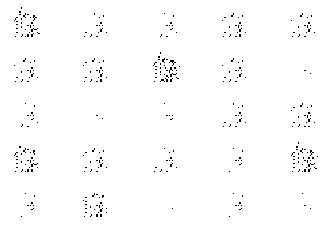

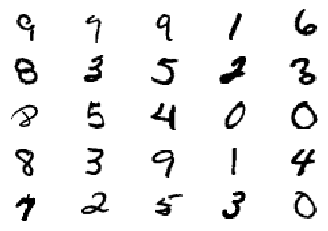

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:31<00:00,  2.20it/s]


tf.Tensor(0.021050492, shape=(), dtype=float32)
tf.Tensor(7.4154596, shape=(), dtype=float32)


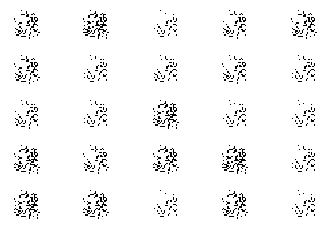

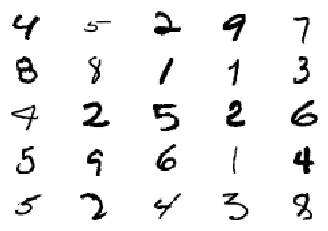

 46%|██████████████████████████████████████                                            | 32/69 [00:17<00:20,  1.79it/s]

KeyboardInterrupt: 

In [16]:
paso_actual = 0
media_perdida_generador = 0
media_perdida_discriminador = 0

for epoch in range(n_epochs):
    
#     for real, _ in dataset:
    for real, _ in tqdm.tqdm(dataset):
        actual_tamanho_batch = len(real)
        
        with tf.GradientTape() as tape:
            perdida_discriminador = obtener_perdida_discriminador(generador, discriminador, real, actual_tamanho_batch, dim_z)
            gradiente_discriminador = tape.gradient(perdida_discriminador, discriminador.trainable_variables)
            discriminador_optimizador.apply_gradients(zip(gradiente_discriminador, discriminador.trainable_variables))
        
        media_perdida_discriminador += perdida_discriminador / actual_tamanho_batch
            
        with tf.GradientTape() as tape:
            perdida_generador = obtener_perdida_generador(generador, discriminador, actual_tamanho_batch, dim_z)
            gradiente_generador = tape.gradient(perdida_generador, generador.trainable_variables)
            generador_optimizador.apply_gradients(zip(gradiente_generador, generador.trainable_variables))
        
        media_perdida_generador += perdida_generador / actual_tamanho_batch
    
    print(media_perdida_discriminador)
    print(media_perdida_generador)
    
#     print(gradiente_discriminador[0][0])
    
    mostrar_imagenes(generador(obtener_ruido(actual_tamanho_batch, dim_z)).numpy(), num_images=25, size=(28, 28))
    mostrar_imagenes(real.numpy(), num_images=25, size=(28, 28))